# Armita Bahrudi - 810100591

Artificial Intelligence - CA#04: *Machine Learning* - fall 1402 \
In this notebook, We use ML to estimate possible purchases from a store .

## Dataset Introduction

|Column|Description|
|--|--|
|ID|Customer's unique identifier|
|Year Birth|Customer's birth year|
|Education|Customer's education level|
|Marital Status|Customer's marital status|
|Income|Customer's yearly household income|
|Kidhome|Number of children in customer's household|
|Teenhome|Number of teenagers in customer's household|
|Dt_Customer|Date of customer's enrollment with the company|
|Recency|Number of days since customer's last purchase|
|Complain|If the customer complained in the last 2 years, 0 1 otherwise|
|MntCoffee|Amount spent on coffee in last 2 years|
|MntFruits|Amount spent on fruits in last 2 years|
|MntMeatProducts|Amount spent on meat in last 2 years|
|MntFishProducts|Amount spent on fish in last 2 years|
|MntSweetProducts|Amount spent on sweets in last 2 years|
|MntGoldProds|Amount spent on gold in last 2 years|
|NumPurchases|Number of purchased products in last 2 years|
|UsedCampaignOffer|If the customer has used a campaign offer, otherwise 0 1|
|NumWebVisitsMonth|Number of visits to company’s website in the last month|

## Preparation

In [53]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.metrics import (
    confusion_matrix, classification_report, ConfusionMatrixDisplay, 
    accuracy_score, precision_score, recall_score, f1_score
    )

from tqdm import tqdm

from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from mlxtend.evaluate import bias_variance_decomp
from xgboost import XGBClassifier
from sklearn import tree


In [54]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as cat_enc
pd.options.mode.chained_assignment = None


In [55]:
DATASET_ADDRESS = "marketing_campaign.csv"
High_CORRELATION_THRESHOLD = 0.15
SELECTED_FEATURES_COUNT = 4
DELETE_THRESHOLD = 0.5
TEST_PORTION = 0.1
SPLIT_RATIO = 0.2
RANDOM_STATE = 18


## EDA

### Exploratory Data Analysis

In [56]:
dataset = pd.read_csv(DATASET_ADDRESS)

In [57]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2240 non-null   int64  
 1   ID                 2240 non-null   int64  
 2   Year_Birth         2240 non-null   int64  
 3   Education          2240 non-null   object 
 4   Marital_Status     2240 non-null   object 
 5   Income             2017 non-null   float64
 6   Kidhome            2240 non-null   int64  
 7   Teenhome           2240 non-null   int64  
 8   Dt_Customer        2240 non-null   object 
 9   Recency            2240 non-null   int64  
 10  MntCoffee          2035 non-null   float64
 11  MntFruits          2240 non-null   int64  
 12  MntMeatProducts    2240 non-null   int64  
 13  MntFishProducts    2240 non-null   int64  
 14  MntSweetProducts   2240 non-null   int64  
 15  MntGoldProds       2227 non-null   float64
 16  NumWebVisitsMonth  2040 

In [58]:
dataset.describe()

,Unnamed: 0,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntCoffee,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,Complain,NumPurchases,UsedCampaignOffer
count,2240.000000,2240.000000,2240.000000,2017.000000,2240.000000,2240.000000,2240.000000,2035.000000,2240.000000,2240.000000,2240.000000,2240.000000,2227.000000,2040.000000,2240.000000,2240.000000,2240.000000
mean,1119.500000,5592.159821,1968.805804,52297.080317,0.437946,0.506250,49.109375,304.239312,26.302232,166.950000,37.525446,27.062946,43.847777,5.326961,0.009375,14.862054,0.271875
std,646.776623,3246.662198,11.984069,25543.108215,0.563666,0.544538,28.962453,337.515534,39.773434,225.715373,54.628979,41.280498,51.897098,2.439349,0.096391,7.677173,0.445025
min,0.000000,0.000000,1893.000000,2447.000000,-5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,559.750000,2828.250000,1959.000000,35340.000000,0.000000,0.000000,24.000000,23.000000,1.000000,16.000000,3.000000,1.000000,9.000000,3.000000,0.000000,8.000000,0.000000
50%,1119.500000,5458.500000,1970.000000,51369.000000,0.000000,0.000000,49.000000,177.000000,8.000000,67.000000,12.000000,8.000000,24.000000,6.000000,0.000000,15.000000,0.000000
75%,1679.250000,8427.750000,1977.000000,68316.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.000000,50.000000,33.000000,56.000000,7.000000,0.000000,21.000000,1.000000
max,2239.000000,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,20.000000,1.000000,44.000000,1.000000


### Missing Data 

In [59]:
def get_missing_values(df: pd.DataFrame):
    total_entities = len(df)
    missing_values = df.isna().sum()
    missing_proportion = (missing_values / total_entities) * 100
    return pd.DataFrame({'feature':missing_values.index, 'Count':missing_values.values, 'Percent':missing_proportion.values})

lost_values = get_missing_values(dataset)
lost_values

,feature,Count,Percent
0,Unnamed: 0,0,0.000000
1,ID,0,0.000000
2,Year_Birth,0,0.000000
3,Education,0,0.000000
4,Marital_Status,0,0.000000
5,Income,223,9.955357
6,Kidhome,0,0.000000
7,Teenhome,0,0.000000
8,Dt_Customer,0,0.000000
9,Recency,0,0.000000


### Correlation

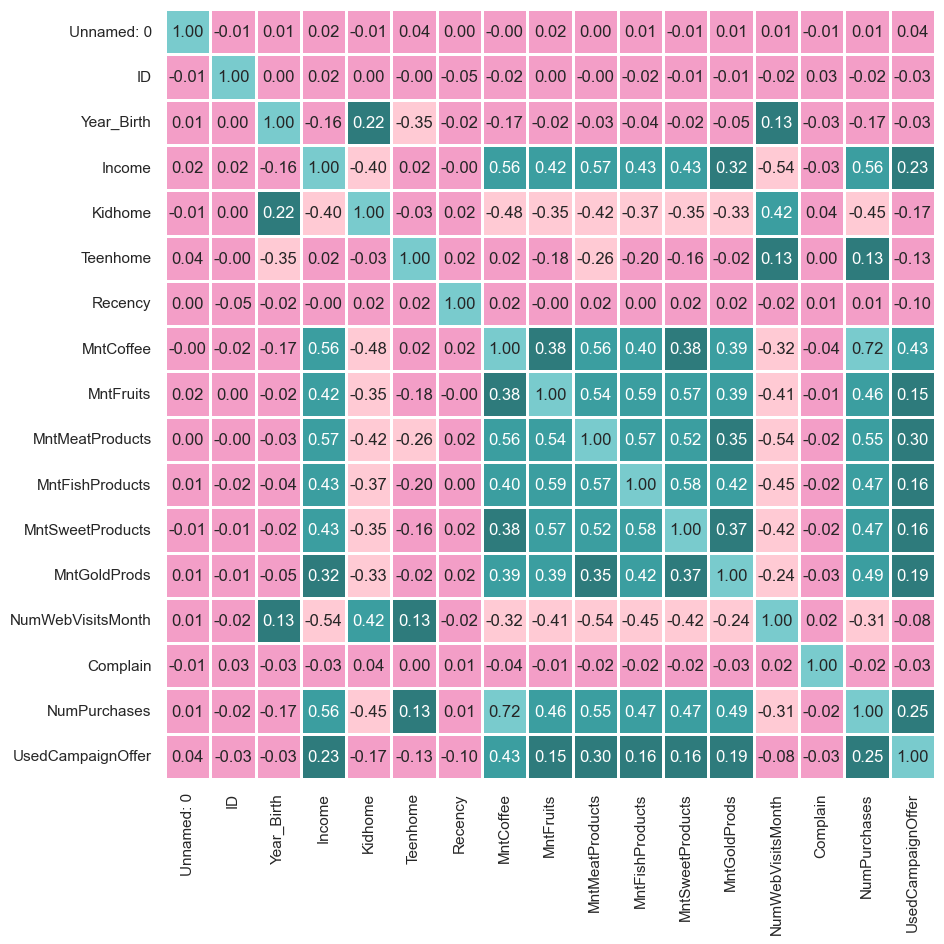

In [60]:
correlation_matrix = dataset.corr(method='pearson', numeric_only=True)

sns.set_style('whitegrid')
##palette = 
palette = ["#FFCAD4", "#F39EC7", "#2E7B7C", "#3B9EA0", "#79CBCD"]
color_map = sns.color_palette(palette=palette, as_cmap=True)
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=2, cbar=False, cmap=color_map, square=True)
plt.show()

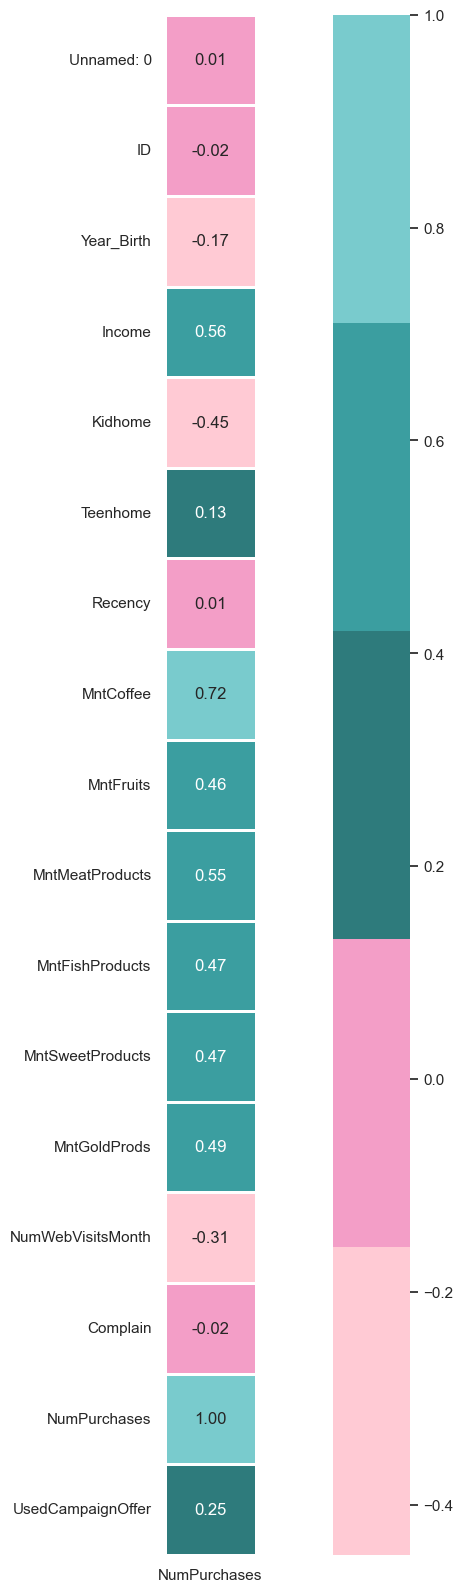

In [61]:
corr = correlation_matrix[['NumPurchases']]

plt.figure(figsize=(20, 20))
cmap = sns.color_palette(palette=palette, as_cmap=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap = cmap, linewidths=1, square=True)
plt.show()

In [62]:
outcomes = correlation_matrix['NumPurchases'].drop('NumPurchases').sort_values(ascending=False)
outcomes

MntCoffee            0.715164
Income               0.562603
MntMeatProducts      0.554229
MntGoldProds         0.493939
MntSweetProducts     0.472876
MntFishProducts      0.469454
MntFruits            0.455461
UsedCampaignOffer    0.251386
Teenhome             0.133163
Unnamed: 0           0.007169
Recency              0.005740
Complain            -0.020583
ID                  -0.023834
Year_Birth          -0.168304
NumWebVisitsMonth   -0.309666
Kidhome             -0.447073
Name: NumPurchases, dtype: float64

As we can see, the ```MntCoffee```, ```Income```, ```MntMeatProducts```, and ```MntGoldProds``` columns have the most correlation with the ``NumPurchases`` column.(*MntCoffee* has the highest)

### Frequency plot of each value for labels with high correlation

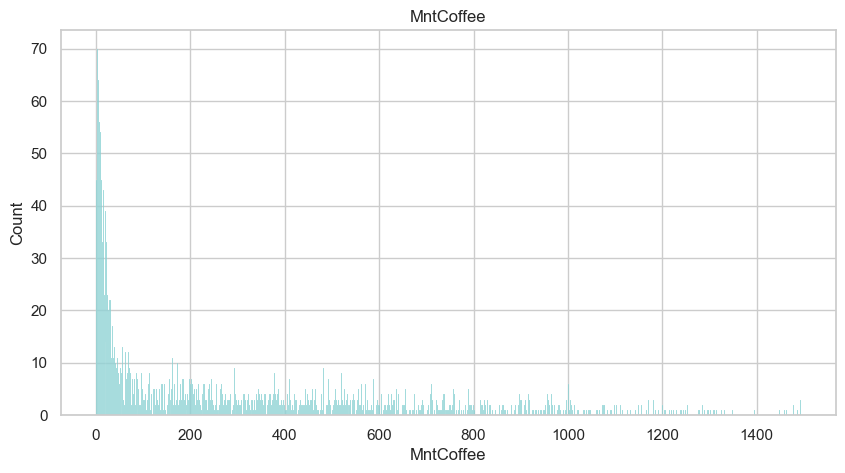

col: MntCoffee     min: 0.0     max: 1493.0


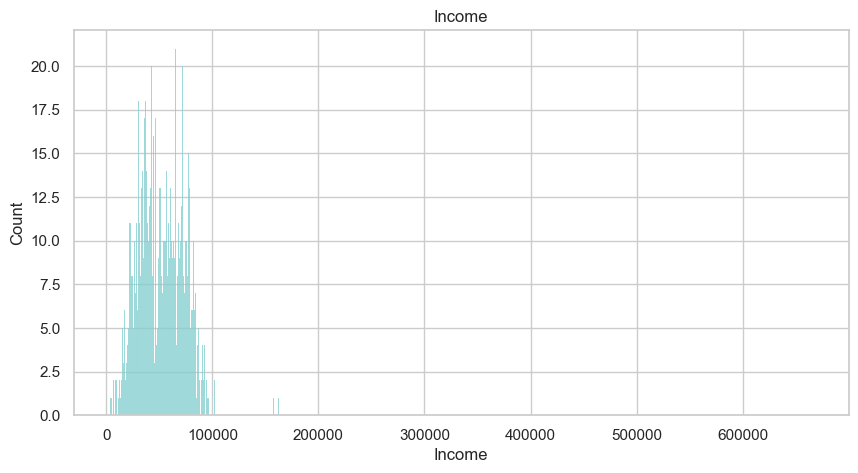

col: Income     min: 2447.0     max: 666666.0


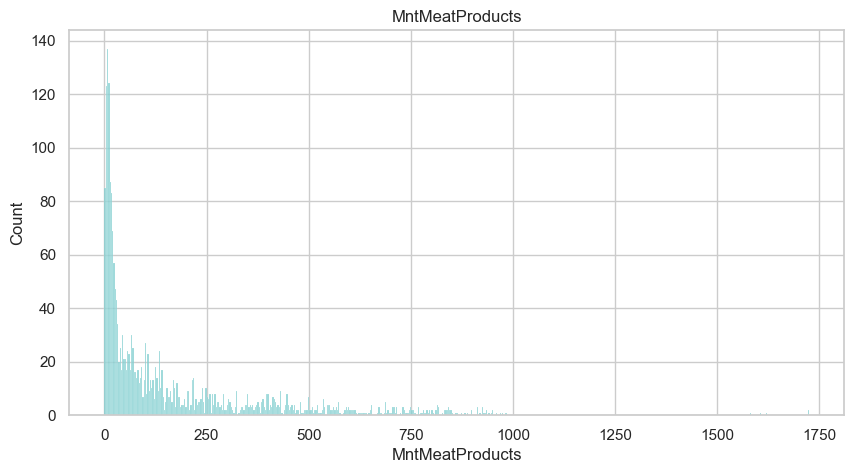

col: MntMeatProducts     min: 0     max: 1725


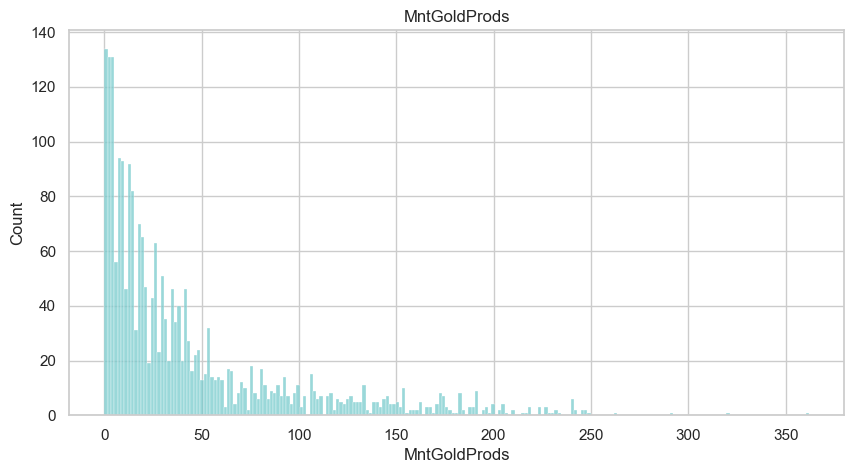

col: MntGoldProds     min: 0.0     max: 362.0


In [63]:
for col in outcomes.index[:SELECTED_FEATURES_COUNT]:
    plt.figure(figsize=(10, 5))
    sns.histplot(dataset[col], bins=len(dataset[col].unique()), color="#79CBCD")
    plt.title(f'{col}')
    plt.show()
    print(f'col: {col}     min: {dataset[col].min()}     max: {dataset[col].max()}')

### Visualizing Correlation Between Features and Target

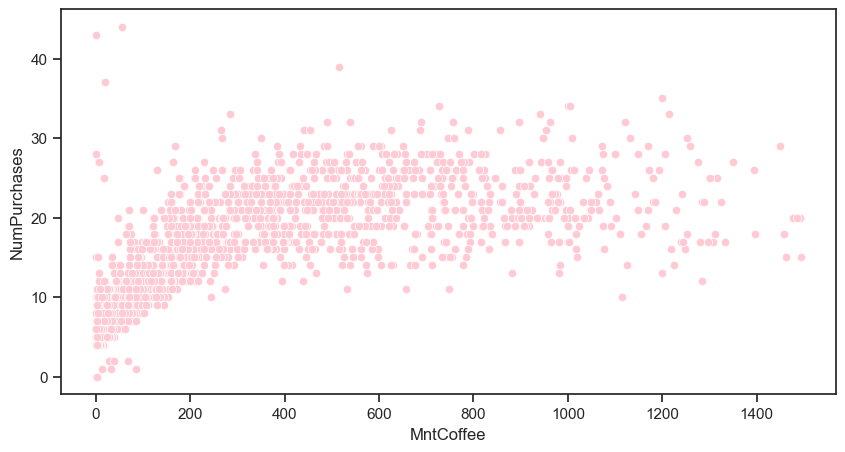

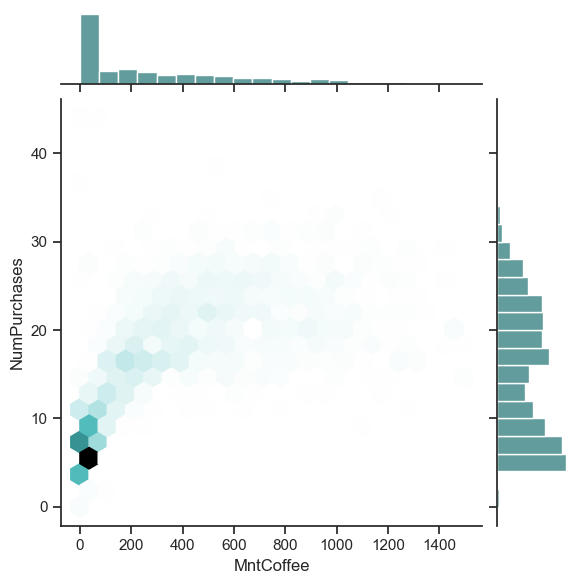

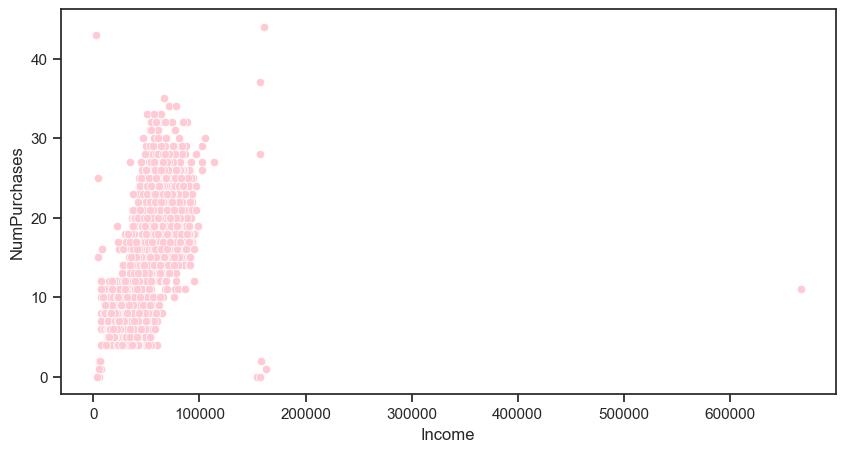

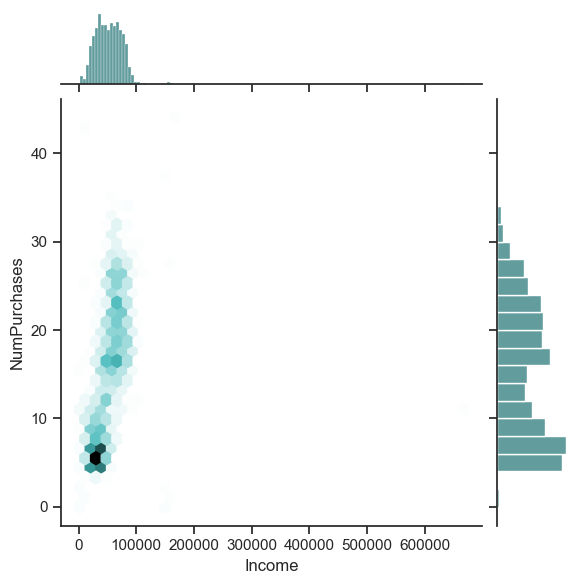

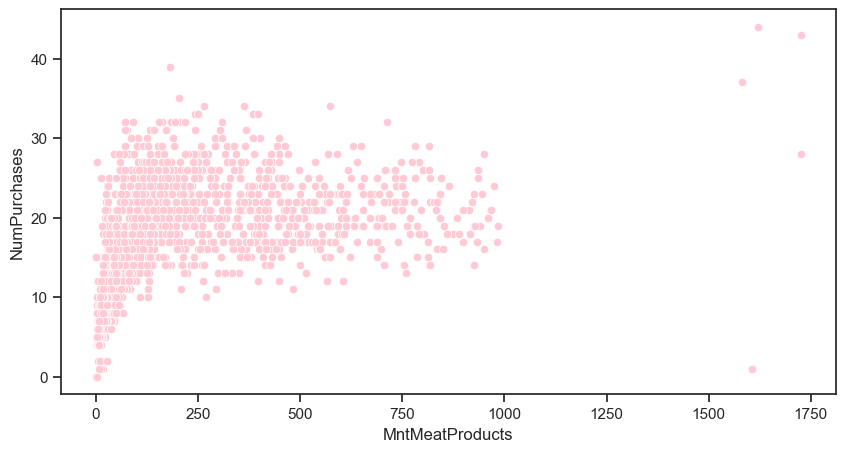

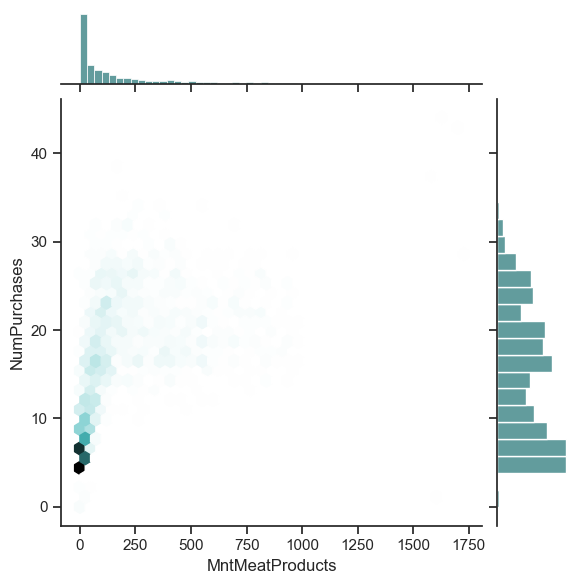

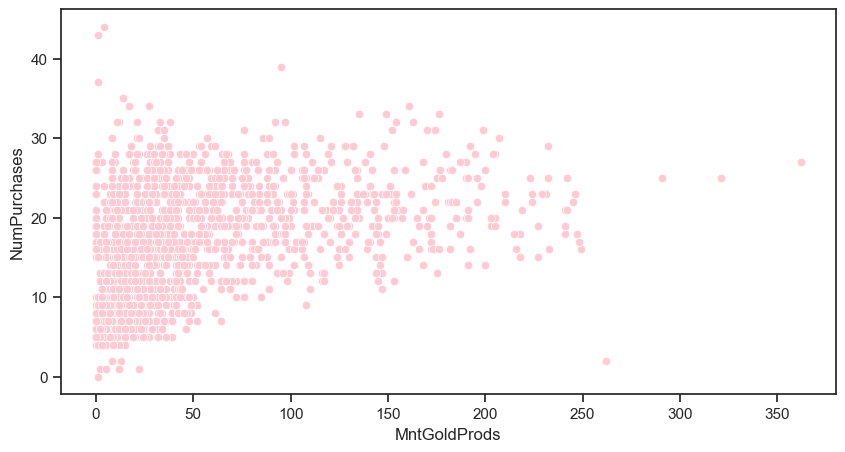

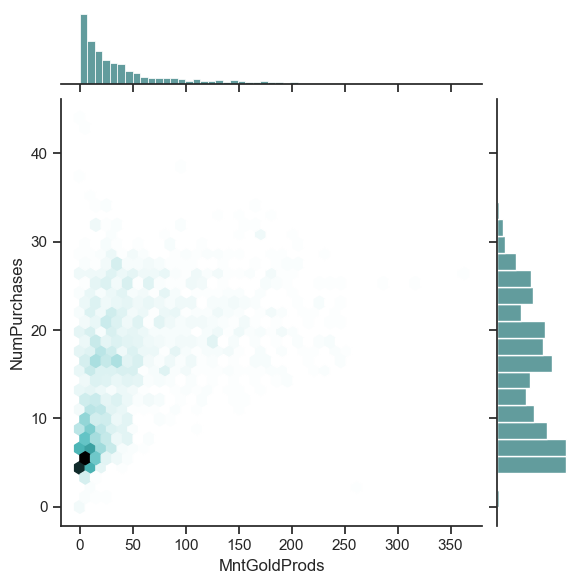

In [64]:
sns.set_theme(style="ticks", palette=palette)
for col in outcomes.index[:SELECTED_FEATURES_COUNT]:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(x=col, y='NumPurchases', data=dataset)
    sns.jointplot(x=col, y='NumPurchases', data=dataset, kind='hex', color="#2E7B7C")
    plt.show()

### More information about data

<Axes: title={'center': 'Number of samples per feature'}, xlabel='NumPurchases'>

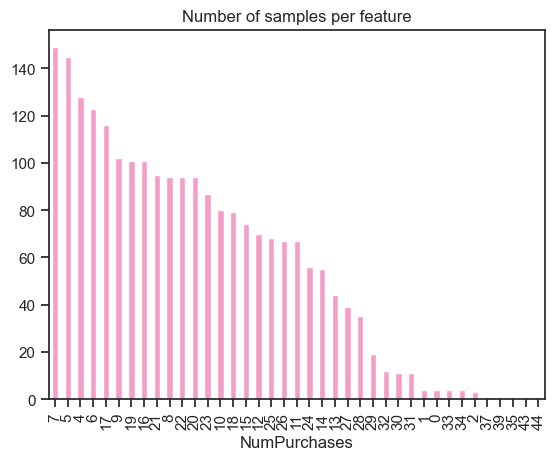

In [65]:
labels_freq = dataset['NumPurchases'].value_counts()
labels_freq.plot(
    kind='bar', 
    title='Number of samples per feature',
    color= "#F39EC7"
    )

## Data Preprocessing

### Handel Missing Values

#### 1. Removing Data
- **Complete Case Analysis (CCA)**: This method involves discarding records with missing values. While this approach is straightforward, it can lead to a significant loss of information if the missing values are prevalent.
#### 2. Imputation
- **Mean/Median/Mode Imputation**: Replace missing values with the mean, median, or mode of the feature. This approach helps retain all data for analysis but may introduce bias.
#### 3. Prediction
- **Predictive Imputation**: Use machine learning algorithms to predict missing values based on other features. This approach can provide more accurate estimates than simple imputation methods.
### 4. Consider the Missingness
- **Use an Indicator Variable**: Create an additional binary feature to indicate whether the data was missing. This can help the model learn how to handle missing data more effectively.



As you saw have some missing data in ```MntCoffee```, ```Income```, ```NumWebVisitsMonth```, and ```MntGoldProds``` labels.

In [66]:
lost_values

,feature,Count,Percent
0,Unnamed: 0,0,0.000000
1,ID,0,0.000000
2,Year_Birth,0,0.000000
3,Education,0,0.000000
4,Marital_Status,0,0.000000
5,Income,223,9.955357
6,Kidhome,0,0.000000
7,Teenhome,0,0.000000
8,Dt_Customer,0,0.000000
9,Recency,0,0.000000


In [67]:
def handle_missing_data(_df: pd.DataFrame, loss_values_stats: pd.DataFrame, del_threshold: float = 0.5, restricted_col=['NumPurchases']):
    mean_kind = ['i', 'f']
    mode_kind = ['O']
    df = _df.copy(deep=True)
    for feature, percent in zip(loss_values_stats['feature'], loss_values_stats['Percent']):
        if percent == 0 or feature in restricted_col:
            continue
        elif percent >= del_threshold * 100:
            df.drop(feature, axis=1, inplace=True)
        elif df[feature].dtype.kind in mean_kind:
            df[feature].fillna(df[feature].mean(), inplace=True)
        elif df[feature].dtype.kind in mode_kind:
            df[feature].fillna(df[feature].mode()[0], inplace=True)
            
    return df

In [68]:
fixed = handle_missing_data(dataset, lost_values)
test = get_missing_values(fixed)
test

,feature,Count,Percent
0,Unnamed: 0,0,0.0
1,ID,0,0.0
2,Year_Birth,0,0.0
3,Education,0,0.0
4,Marital_Status,0,0.0
5,Income,0,0.0
6,Kidhome,0,0.0
7,Teenhome,0,0.0
8,Dt_Customer,0,0.0
9,Recency,0,0.0


### Normalize and Standardize

Feature scaling is a critical preprocessing step in machine learning that helps to normalize the range of independent variables or features in the dataset. Also, this helps algorithms to converge faster. Here, let's delve into the common feature scaling algorithms and their significance:

- **Equal Weighage**: Scaling ensures that all features contribute equally to the analysis and model training process, preventing features with larger scales from dominating those with smaller scales.
- **Algorithms Sensitivity**: Many machine learning algorithms, such as k-Nearest Neighbors (KNN), Support Vector Machines (SVM), and Principal Component Analysis (PCA), are sensitive to the relative scales of the features. Feature scaling helps these algorithms perform better.

1. **Normalization (Min-Max Scaling)**:
   - **Formula**: $$x_i = \frac{x_i - min(X)}{max(X) - min(X)}$$
   - **Range**: Transforms features to a specific range (commonly $[0,1]$ or $[-1,1]$).
   - **Use Case**: Particularly useful when the features have a bounded minimum and maximum value.

2. **Standardization**:
   - **Formula**: $$x_{i} = \frac{x_{i} - mean(X)}{StandardDeviation(X)}$$
   - **Mean and Standard Deviation**: Transforms features to have a mean of 0 and a standard deviation of 1.
   - **Use Case**: useful when the feature distribution is Normal or Gaussian, not bound to a specific range, and when dealing with outliers.

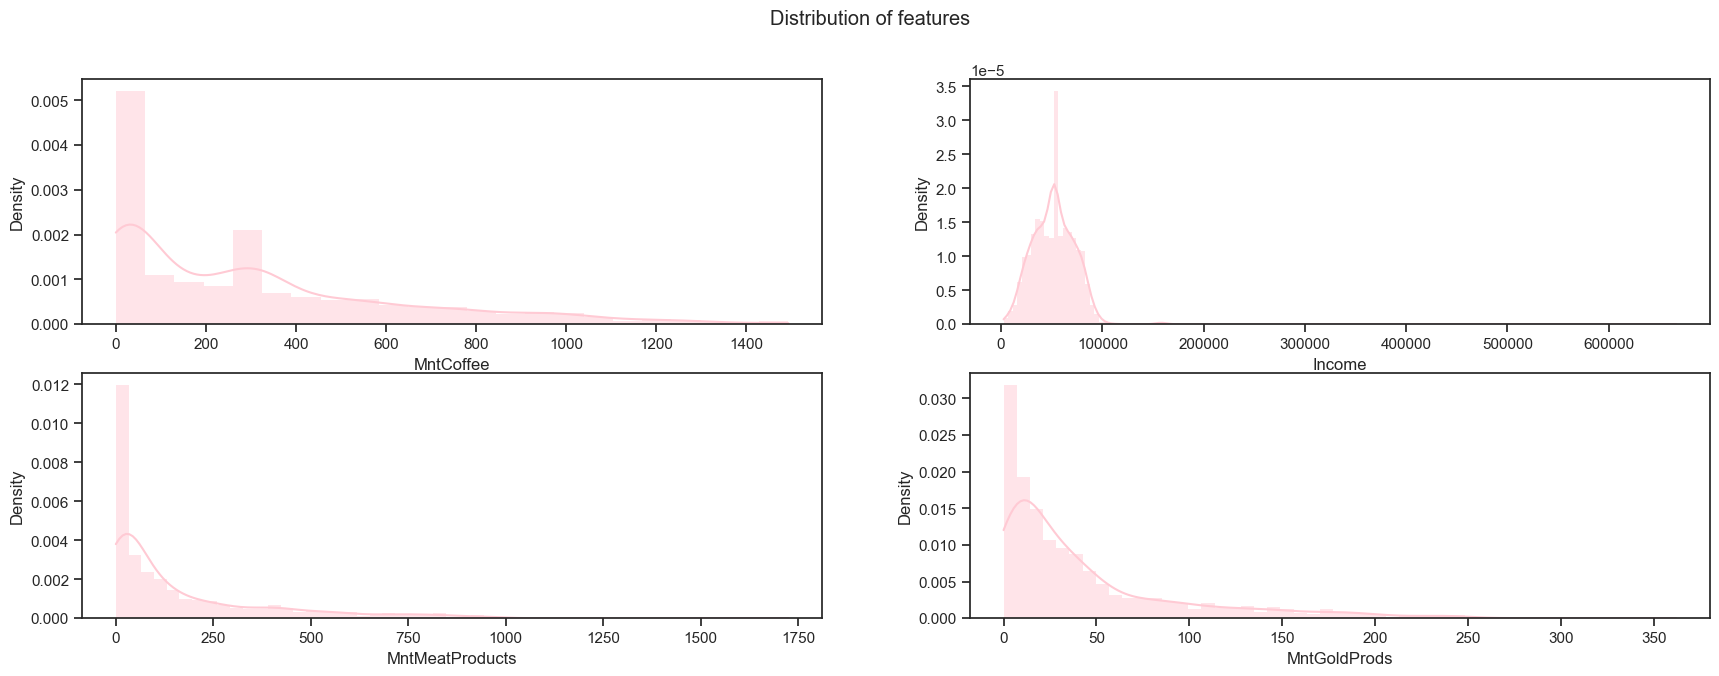

In [69]:
def plot_distribution(data, features):
    fig, ax = plt.subplots(nrows=(len(features)+1)//2, ncols=2, figsize=(21,7))
    fig.suptitle(f"Distribution of features")
    i, j = 0, 0
    for f in features:
        sns.histplot(data[f], ax=ax[i][j], kde=True, stat="density", linewidth=0)
        i += j
        j = 1 - j
    plt.show()

plot_distribution(fixed,outcomes.index[:SELECTED_FEATURES_COUNT])


We use Standardization scaling because of Normal distribution of our data.

In [70]:
std_scaler = StandardScaler()
numerical_columns = fixed.select_dtypes(include=['int64', 'float64']).columns 
numerical_columns = numerical_columns.drop('NumPurchases')
fixed[numerical_columns] = std_scaler.fit_transform(fixed[numerical_columns])
fixed[['MntCoffee', 'NumPurchases']].head()

,MntCoffee,NumPurchases
0,1.028416,25
1,0.000000,6
2,0.000000,21
3,-0.911752,8
4,-0.408055,19


### preprocessing object/str data

There are several ways for encoding object type features to numerical values.
- LabelEncoder: assigns a number to each categorical value 
    - better not to use if we have more than two category
- OneHotEncoder: assigns one bit to each category and when the sample is a member of it, set that bit to 1 and otherwise set it to 0.
    - works fine if we have more than two category
- OrdinalEncoder: assigns a sequence of numbers to categories
    - better to use when categories are inherently ordered

We don't need to use this approaches for all columns with type str/object. 
actually, we need to drop some columns such as *name*.
in such cases, all values could be unique and they won't help our model and in some cases hey could let to ***``Overfitting``*** model.

In [71]:
def handle_object_data(_df: pd.DataFrame, restricted=[]):
    one_hot_encoder = OneHotEncoder(sparse_output=False)
    ordinal_encoder = OrdinalEncoder()
    numeric_scaler = StandardScaler()
    label_encoder = LabelEncoder()
    df = _df.copy(deep=True)
    for l in df.columns:
        if l in restricted:
            continue
        if df[l].dtype.kind == 'O':
            categories = df[l].unique()
            if l == 'Education':
                categories = ['Master', 'PhD', 'Graduation', '2n Cycle', 'Basic']
                df[l] = ordinal_encoder.fit_transform(df[l].values.reshape(-1, 1))
            elif l == 'Dt_Customer':
                for i in range(len(df[l])):
                    df[l][i] = int(df[l][i][6:])
                df[l] = numeric_scaler.fit_transform(df[l].values.reshape(-1, 1))
            elif len(categories) <= 2:
                df[l] = label_encoder.fit_transform(df[l].values.reshape(-1, 1))
            elif len(categories) >= 200:
                df.drop(l, axis=1, inplace=True)
            else:
                df[l] = one_hot_encoder.fit_transform(df[l].values.reshape(-1, 1))
            continue
    return df

In [72]:
dataset_standardized = handle_object_data(fixed, restricted=['NumPurchases'])
dataset_standardized.describe()

,Unnamed: 0,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntCoffee,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,Complain,NumPurchases,UsedCampaignOffer
count,2240.000000,2.240000e+03,2.240000e+03,2240.000000,2240.000000,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2.240000e+03,2240.000000,2.240000e+03
mean,0.000000,2.220446e-17,-8.133970e-15,2.393750,0.000893,-7.930164e-17,5.392512e-17,-3.172066e-18,-6.644130e-14,-3.172066e-18,-6.344132e-18,-2.379049e-17,4.123686e-17,1.506731e-17,-1.506731e-17,1.427430e-16,-8.247371e-17,-3.053113e-17,14.862054,3.806479e-17
std,1.000223,1.000223e+00,1.000223e+00,1.124797,0.029874,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,1.000223e+00,7.677173,1.000223e+00
min,-1.731278,-1.722818e+00,-6.326960e+00,0.000000,0.000000,-2.057173e+00,-9.649610e+00,-9.298944e-01,-1.502225e+00,-1.696001e+00,-9.459542e-01,-6.614492e-01,-7.398135e-01,-6.870680e-01,-6.557331e-01,-8.475512e-01,-2.288869e+00,-9.728167e-02,0.000000,-6.110569e-01
25%,-0.865639,-8.514982e-01,-8.184192e-01,2.000000,0.000000,-6.343421e-01,-7.771339e-01,-9.298944e-01,-4.109430e-02,-8.671566e-01,-8.620046e-01,-6.363012e-01,-6.689119e-01,-6.321399e-01,-6.315032e-01,-6.735866e-01,-5.701636e-01,-9.728167e-02,8.000000,-6.110569e-01
50%,0.000000,-4.117757e-02,9.967091e-02,2.000000,0.000000,0.000000e+00,-7.771339e-01,-9.298944e-01,-4.109430e-02,-3.777284e-03,-2.417105e-01,-4.602650e-01,-4.429132e-01,-4.673554e-01,-4.618937e-01,-3.643162e-01,0.000000e+00,-9.728167e-02,15.000000,-6.110569e-01
75%,0.865639,8.735813e-01,6.839101e-01,3.000000,0.000000,5.814825e-01,9.973614e-01,9.069340e-01,-4.109430e-02,8.596020e-01,4.811887e-01,1.684356e-01,2.882592e-01,2.284015e-01,1.438543e-01,2.348952e-01,7.188653e-01,-9.728167e-02,21.000000,1.636509e+00
max,1.731278,1.724876e+00,2.269702e+00,4.000000,1.000000,2.535329e+01,2.771857e+00,2.743762e+00,1.420036e+00,1.722981e+00,3.696147e+00,4.343008e+00,6.904261e+00,4.055064e+00,5.716737e+00,6.149691e+00,6.304657e+00,1.027943e+01,44.000000,1.636509e+00


### Drop values

- we could drop columns with poor correlation with target
- some columns could be exclusive like *ID* and can't help us, so we will delete these columns
- maybe there is a lot of missing values 


### Separate Dataset for T&T

We need to split a dataset into train and test sets to evaluate how well our machine learning model performs.
The train set is used to fit the model, and the statistics of the train set are known.
The second one is used for prediction and evaluating model.

We can split our dataset into train and test part:
- stratified sampling:
    - splitting dataset and assign one part as train and the other as test
    - works fine with class imbalance datasets
- random sampling:
    - defining portion of each section and choose each sample randomly
    - works best for class balance datasets

Generally, we use libraries for this purpose:
- `train_test_split()` from `scikit-learn`
- `randn()` from `numpy`
- `sample()` from `pandas`

By splitting dataset into train and test, we can evaluate our model performance. for example, if training accuracy is extremely high, but the testing accuracy is poor, it would be a good sign of overfitting.

Splitting ratio is usually like $(Train, Test) \in [(0.8, 0.2), (0.75, 0.25), (\frac{2}{3}, \frac{1}{3})]$.

In [73]:
y = dataset_standardized['NumPurchases']
x = dataset_standardized.drop('NumPurchases', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=SPLIT_RATIO, random_state=RANDOM_STATE)

### Validation Data

Validation set(Development set): we use it to fine-tune the model hyperparameters. 
Agent won't learn from this data and effects indirectly. 
We use the validation set results, to update higher level hyperparameters.

### K-Fold cross validation Method

In this method, we divide the dataset into k parts and train the model k times, each time we consider one of these k parts as train data and the other part as test data. The value of k depends on various factors such as the size and structure of the dataset, hardware, etc., but k=5 and k=10 are very common. k accuracy is calculated and the average of these is calculated as the accuracy of the model. The value of k depends on various factors such as the size and structure of the dataset, hardware, etc., but k=5 and k=10 are very common.

## Linear Regression

Main form of simple linear regression function:
$$f(x) = \alpha x + \beta$$

here we want to find the bias ($\alpha$) and slope($\beta$) by minimizing the derivation of the Residual Sum of Squares (RSS) function:

- step 1: Compute RSS of the training data  

$$ RSS = \Sigma (y_i - (\hat{\beta} + \hat{\alpha} * x_i) )^2 $$

- step 2: Compute the derivatives of the RSS function in terms of $\alpha$ and $\beta$, and set them equal to 0 to find the desired parameters

$$ \frac{\partial RSS}{\partial \beta} = \Sigma (-f(x_i) + \hat{\beta} + \hat{\alpha} * x_i) = 0$$
$$ \to \beta = \hat{y} - \hat{\alpha} \hat{x} \to (1)$$


$$ \frac{\partial RSS}{\partial \alpha} = \Sigma (-2 x_i y_i + 2 \hat{\beta} x_i + 2\hat{\alpha} x_i ^ 2) = 0 \to (2)$$

$$ (1) , (2) \to \hat{\alpha} = \frac{\Sigma{(x_i - \hat{x})(y_i - \hat{y})}}{\Sigma{(x_i - \hat{x})^2}}
$$
$$ \hat{\beta} = y - \hat{a} x$$


Based on the above formula, implement the function below to compute the parameters of a simple linear regression

In [74]:
def simple_linear_regression(input_feature, output):
    input_feature_mean = input_feature.mean()
    output_mean = output.mean()
    
    output_input_feature_product = ((output - output_mean) * (input_feature - input_feature_mean)).sum()
    input_feature_squared = ((input_feature - input_feature_mean) ** 2).sum()

    slope = output_input_feature_product / input_feature_squared
    intercept = output_mean - (slope * input_feature_mean)
    return (intercept, slope)

In [75]:
def get_regression_predictions(input_feature, bias, slope):
    predicted_values = bias + (slope * input_feature)
    return (predicted_values)

### Evaluation Metrics

* ```Residual Sum of Squares (RSS)```: 
    - This metric measures the sum of the squared differences between the predicted and actual values.
    - It is calculated by taking the sum of the squared differences between the predicted and actual values.

* ```Mean Squared Error (MSE)```: 
    - This metric measures the average squared difference between the predicted and actual values.
    - It is calculated by taking the average of the squared differences between the predicted and actual values.
    - MSE has the advantage of penalizing large errors more than smaller ones due to the squaring.

* ```Root Mean Squared Error (RMSE)```: 
    - This metric measures the average squared difference between the predicted and actual values.
    - It is calculated by taking the square root of the MSE.
    - RMSE is in the same unit as the target variable and provides an interpretable indication of the typical prediction error.

* ```Mean Absolute Error (MAE)```: 
    - This metric measures the average absolute difference between the predicted and actual values.
    - It is calculated by taking the average of the absolute differences between the predicted and actual values.
    - Compared to RMSE, MAE is less sensitive to large errors as it does not square the differences.

* ```R-Squared (R2)```:  
    - This metric measures the proportion of the variance in the target variable that is explained by the model.
    - It is calculated by taking the ratio of the variance of the predicted values to the variance of the actual values.
    - R2 ranges from 0 to 1, where 1 indicates a perfect fit and 0 or negative values indicate a poor fit.

* ```Adjusted R-Squared (Adj R2)```: 
    - This metric also measures the proportion of the variance in the target variable that is explained by the model.
    - It is calculated by taking the ratio of the variance of the predicted values to the variance of the actual values, adjusted for the number of features in the model.
    - The adjustment accounts for the number of features in the model, effectively penalizing for excessive, non-contributory features.

These metrics collectively provide insights into the accuracy, goodness of fit, and generalization capability of the regression model. It's important to use ``a combination of these metrics`` to have a comprehensive understanding of the model's performance.




Now that we have a model and can make predictions, let's evaluate our model using Root Mean Square Error (RMSE). RMSE is the square root of the mean of the squared differences between the residuals, and the residuals is just a fancy word for the difference between the predicted output and the true output.

In [76]:
def get_root_mean_square_error(predicted_values, outputs):
    residuals = predicted_values - outputs
    residuals_squared = residuals ** 2
    RMSE = np.sqrt(residuals_squared.mean())

    return(RMSE)

The RMSE has no bound, thus it becomes challenging to determine whether a particular RMSE value is considered good or bad without any reference point. Instead, we use R2 score. The R2 score is calculated by comparing the sum of the squared differences between the actual and predicted values of the dependent variable to the total sum of squared differences between the actual and mean values of the dependent variable. The R2 score is formulated as below:

$$R^2 = 1 - \frac{SSres}{SStot} = 1 - \frac{\sum_{i=1}^{n} (y_{i,true} - y_{i,pred})^2}{\sum_{i=1}^{n} (y_{i,true} - \bar{y}_{true})^2} $$

In [77]:
def get_r2_score(predicted_values, outputs):
    residuals = predicted_values - outputs

    residuals_squared = residuals ** 2
    SSres = residuals_squared.sum()
    
    SStot = ((outputs - outputs.mean()) ** 2).sum()
    
    R2_score = 1 - (SSres / SStot)

    return(R2_score)

Now calculate the fitness of the model with the features withe have highest correlations. highest correlation would give use best accuracy.

In [78]:
designated_feature_list = outcomes.index[:SELECTED_FEATURES_COUNT].tolist()
scores_df = pd.DataFrame(columns=['RMSE', 'R2_score'])
for f in designated_feature_list:
    bias, slope = simple_linear_regression(x_train[f], y_train)
    predicted_values = get_regression_predictions(x_test[f], bias, slope)
    RMSE = get_root_mean_square_error(predicted_values, y_test)
    R2_score = get_r2_score(predicted_values, y_test)
    scores_df.loc[f] = [RMSE, R2_score]

scores_df

,RMSE,R2_score
MntCoffee,5.918903,0.421499
Income,9.552264,-0.506726
MntMeatProducts,6.352667,0.333602
MntGoldProds,6.812978,0.233530


## Multiple Regression

Multiple regression is a statistical technique that aims to model the relationship between a dependent variable and two or more independent variables.

Multiple regression with n independent variables is expressed as follows:

$$f(x) = \beta _{0} + \beta_{1} x_{1} + \beta_{2} x_{2} + \beta_{3} x_{3} + \beta_{4} x_{4} + ... + \beta_{n} x_{n} + c $$

To optimize the model for accurate predictions, multiple regression commonly employs iterative algorithms such as gradient descent.

The main goal of the optimization process is to make our predictions as close as possible to the actual values.
We measure the prediction error using a cost function, usually denoted as $J(\beta)$.

$$ J(\beta)= \frac {1}{2m} Σ_{i=0}^{m-1}(y_i - (\hat \beta _{0} + \hat \beta_{1} x_{1} + \hat \beta_{2} x_{2} + \hat \beta_{3} x_{3} + \hat \beta_{4} x_{4} + ... + \hat \beta_{n} x_{n}) )^2  $$

Gradient descent iteratively adjusts the coefficients $(\beta_i)$ to minimize the cost function. The update rule for each coefficient is:

$$\beta_{i} = \beta _ {i} - \alpha \frac {∂J(\beta)}{∂\beta_{i}}$$

$$ \frac {∂J(\beta)}{∂\beta_{i}} = \frac {1}{m}Σ_{j=0}^{m-1}(y_j - (\hat \beta _{0} + \hat \beta_{1} x_{j1} + \hat \beta_{2} x_{j2} + \hat \beta_{3} x_{j3} + \hat \beta_{4} x_{j4} + ... + \hat \beta_{n} x_{jn})) x_{ji} $$



## Predicting output given regression weights

Based on the formula above and [np.dot()](https://numpy.org/doc/stable/reference/generated/numpy.dot.html) method, complete this function to compute the predictions for an entire matrix of features given the matrix, bias, and the weights. Provide an explanation of np.dot method and the reasoning behind using this method in your code:

In [79]:
def predict_output(feature_matrix, weights, bias):
    predictions = np.dot(feature_matrix, weights) + bias
    return predictions


## Computing the Derivative

As we saw, the cost function is the sum over the data points of the squared difference between an observed output and a predicted output.

Since the derivative of a sum is the sum of the derivatives, we can compute the derivative for a single data point and then sum over data points. We can write the squared difference between the observed output and predicted output for a single point as follows:

$$
(output  - (const* w _{0} + [feature_1] * w_{1} + ...+ [feature_n] * w_{n}  ))^2
$$

With n feautures and a const , So the derivative will be :


$$
2 * (output  - (const* w _{0} + [feature_1] * w_{1} + ...+ [feature_n] * w_{n}  ))
$$

The term inside the paranethesis is just the error (difference between prediction and output). So we can re-write this as:

$$2 * error*[feature_i] $$


That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself. In the case of the constant then this is just twice the sum of the errors!

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors.


With this in mind, complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).


In [80]:
def feature_derivative(errors, feature):
    derivative = 2 * np.dot(feature, errors)
    return derivative


## Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of increase and therefore the negative gradient is the direction of decrease and we're trying to minimize a cost function.


The amount by which we move in the negative gradient direction is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. We define this by requiring that the magnitude (length) of the gradient vector to be smaller than a fixed 'tolerance'.


With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent we update the weight for each feature befofe computing our stopping criteria.

In [81]:
def regression_gradient_descent(feature_matrix, outputs, initial_weights, bias, step_size, tolerance):
    weights = np.array(initial_weights)
    converged = False
    while not converged:
        predictions = predict_output(feature_matrix, weights, bias)
        errors = predictions - outputs
        
        gradient = np.zeros(len(weights))
        for i in range(len(weights)):
            derivative = feature_derivative(errors, feature_matrix[:, i])
            weights[i] -= step_size * derivative
        
        bias_derivative = 2 * np.sum(errors)
        bias -= step_size * bias_derivative
        
        gradient_magnitude = np.sqrt(np.sum(derivative ** 2))
        if gradient_magnitude < tolerance:
            converged = True

    return weights, bias

In [82]:
def normalize_features(chosen_features, data_frame):
    for feature in chosen_features:
        data_frame[feature] = (data_frame[feature] - data_frame[feature].mean()) / data_frame[feature].std()
    return data_frame


def n_feature_regression(chosen_feature_matrix, target_matrix, keywords):
    initial_weights = keywords['initial_weights']
    step_size = keywords['step_size']
    tolerance = keywords['tolerance']
    bias = keywords['bias']

    weights, bias = regression_gradient_descent(chosen_feature_matrix, target_matrix, initial_weights, bias, step_size, tolerance)

    return weights, bias

def get_weights_and_bias(chosen_features):
    ###"""
    #Computes the weights and bias for a general n feature model.
    #:param chosen_features:  list of features to perform multiple regression on
    #:return: chosen_feature_matrix, computed weights and bias via regression
    #"""

    # ToDo
    #  Would selecting different initial weights make any difference?
    #  Explain your answer.
    keywords = {
        'initial_weights': np.array([.5]*len(chosen_features)),
        'step_size': 1.e-4,
        'tolerance': 1.e-10,
        'bias': 0
    }

    chosen_feature_dataframe = x_train[chosen_features]
    # ToDo
    #  Why are the features normalized?
    chosen_feature_dataframe = normalize_features(chosen_features, chosen_feature_dataframe)
    chosen_feature_matrix = chosen_feature_dataframe.to_numpy()

    target_column = y_train
    target_matrix = target_column.to_numpy()

    train_weights, bias = n_feature_regression(chosen_feature_matrix, target_matrix, keywords)

    return chosen_feature_matrix, train_weights, bias

the best way is to use data with high correlation:

In [83]:
corr_matrix = dataset_standardized.corr(method='pearson', numeric_only=True)
sorted_features = corr_matrix['NumPurchases'].drop('NumPurchases').sort_values(ascending=False)
sorted_features


MntCoffee            0.682417
MntMeatProducts      0.554229
Income               0.535517
MntGoldProds         0.491491
MntSweetProducts     0.472876
MntFishProducts      0.469454
MntFruits            0.455461
UsedCampaignOffer    0.251386
Teenhome             0.133163
Education            0.094012
Marital_Status       0.018064
Unnamed: 0           0.007169
Recency              0.005740
Complain            -0.020583
ID                  -0.023834
Year_Birth          -0.168304
Dt_Customer         -0.181127
NumWebVisitsMonth   -0.295078
Kidhome             -0.447073
Name: NumPurchases, dtype: float64

### Two Feature Regression

In this part, you should choose 2 features and implement multiple regression on them :

In [84]:
chosen_features2 = ['MntCoffee', 'MntMeatProducts']
chosen_feature_matrix2, train_weights2, bias2 = get_weights_and_bias(chosen_features2)

In [85]:
chosen_feature_dataframe2 = x_test[chosen_features2]
chosen_feature_dataframe2 = normalize_features(chosen_features2, chosen_feature_dataframe2)
chosen_feature_matrix2 = chosen_feature_dataframe2.to_numpy()
gradient_descent2_predicts = predict_output(chosen_feature_matrix2, train_weights2, bias2)

In [86]:
scores_df = pd.DataFrame(columns=['RMSE', 'R2_score'])
RMSE = get_root_mean_square_error(gradient_descent2_predicts, y_test)
R2_score = get_r2_score(gradient_descent2_predicts, y_test)
scores_df.loc[0] = [RMSE, R2_score]

scores_df


,RMSE,R2_score
0,5.48224,0.503708


### Three Feature Regression

Now repeat the steps for 3 features

In [87]:
chosen_features3 = ['MntCoffee', 'MntMeatProducts', 'Income']
chosen_feature_matrix3, train_weights3, bias3 = get_weights_and_bias(chosen_features3)
chosen_feature_dataframe3 = x_test[chosen_features3]
chosen_feature_dataframe3 = normalize_features(chosen_features3, chosen_feature_dataframe3)
chosen_feature_matrix3 = chosen_feature_dataframe3.to_numpy()
gradient_descent3_predicts = predict_output(chosen_feature_matrix3, train_weights3, bias3)
RMSE = get_root_mean_square_error(gradient_descent3_predicts, y_test)
R2_score = get_r2_score(gradient_descent3_predicts, y_test)
scores_df.loc[0] = [RMSE, R2_score]

scores_df



,RMSE,R2_score
0,5.786844,0.447025


### Five Feature Regression

Finally, repeat the steps for 5 features

Explain the differences in the results and the reasoning behind these variations.

In [88]:
chosen_features5 = ['MntCoffee', 'MntMeatProducts', 'Income', 'MntGoldProds', 'MntSweetProducts']
chosen_feature_matrix5, train_weights5, bias5 = get_weights_and_bias(chosen_features5)
chosen_feature_dataframe5 = x_test[chosen_features5]
chosen_feature_dataframe5 = normalize_features(chosen_features5, chosen_feature_dataframe5)
chosen_feature_matrix5 = chosen_feature_dataframe5.to_numpy()
gradient_descent5_predicts = predict_output(chosen_feature_matrix5, train_weights5, bias5)
RMSE = get_root_mean_square_error(gradient_descent5_predicts, y_test)
R2_score = get_r2_score(gradient_descent5_predicts, y_test)
scores_df.loc[0] = [RMSE, R2_score]

scores_df

,RMSE,R2_score
0,5.360599,0.525487


## Classification

In [89]:
median_data = y_train.median()
y_train_class = y_train.apply(lambda x: "HIGH" if x < median_data else "LOW")
median_test = y_test.median()
y_test_class = y_test.apply(lambda x: "HIGH" if x < median_test else "LOW")
y_train_class.describe()


count     1792
unique       2
top        LOW
freq       926
Name: NumPurchases, dtype: object

### Logistic Regression

Logistic regression is a linear model for classification and it usually used when the target is binary. The output of the logistic regression is between 0 and 1 and it is calculated using the sigmoid function. The sigmoid function is as follows:

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$

where $z$ is the activation function. The activation function is calculated using the following formula:

$$z = w_1x_1 + w_2x_2 + ... + w_nx_n + b$$

where $w_i$ is the weight of the $i^{th}$ feature, $x_i$ is the value of the $i^{th}$ feature, $b$ is the bias and $n$ is the number of features.

In [90]:
logReg = LogisticRegression(random_state = 1, solver='lbfgs', max_iter=5000)
logReg.fit(x_train, y_train_class)
logistic_regression_predicted  = logReg.predict(x_test)
print(f'Logistic Regression Accuracy: {logReg.score(x_test, y_test_class) * 100:2.2f}%')

Logistic Regression Accuracy: 92.19%


### KNN

K-Nearest Neighbor is a type of supervised learning algorithm that is mostly used for classification problems. It works by finding the k nearest neighbors to a given data point in the training set, and assigning the class label that is most common among the k neighbors to the data point. KNN is a non-parametric algorithm, which means that it does not make any assumptions about the underlying distribution of the data. KNN is easy to implement and can handle both categorical and numerical data.

In [91]:
NEIGHBORS = 21

In [92]:
KNN = KNeighborsClassifier(n_neighbors=NEIGHBORS)
KNN.fit(x_train, y_train_class)
knn_predicted  = KNN.predict(x_test)
print(f'KNN Accuracy: {KNN.score(x_test, y_test_class) * 100:2.2f}%')

KNN Accuracy: 89.96%


###  Decision Tree

A decision tree is a type of supervised learning algorithm that is mostly used for classification problems. It works by recursively splitting the data into subsets based on the values of the input features, until a stopping criterion is met. The result is a tree-like structure where each internal node represents a test on an input feature, each branch represents the outcome of the test, and each leaf node represents a class label. Decision trees are easy to interpret and can handle both categorical and numerical data.

In [93]:
RANDOM_STATE = 50

In [94]:
decisionTree = DecisionTreeClassifier(random_state=RANDOM_STATE)
decisionTree.fit(x_train, y_train_class)
decision_tree_predicted  = decisionTree.predict(x_test)
print(f'Decision Tree Accuracy: {decisionTree.score(x_test, y_test_class) * 100:2.2f}%')

Decision Tree Accuracy: 91.52%


### Heatmap

In [95]:

logistic_regression_confusion_matrix = confusion_matrix(y_test_class, logistic_regression_predicted)
knn_confusion_matrix = confusion_matrix(y_test_class, knn_predicted)
decision_tree_confusion_matrix = confusion_matrix(y_test_class, decision_tree_predicted)

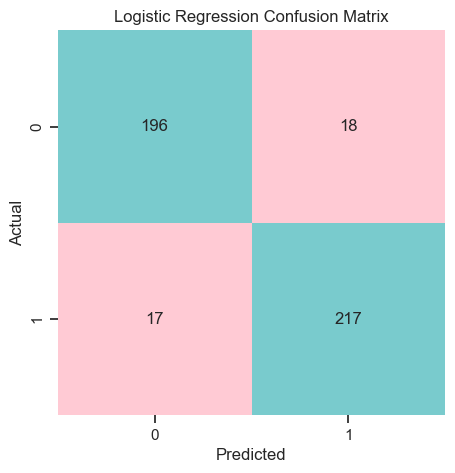

In [96]:
fig = plt.figure(figsize=(5, 5))
sns.heatmap(logistic_regression_confusion_matrix, annot=True, fmt='d', cmap=palette, cbar=False)
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

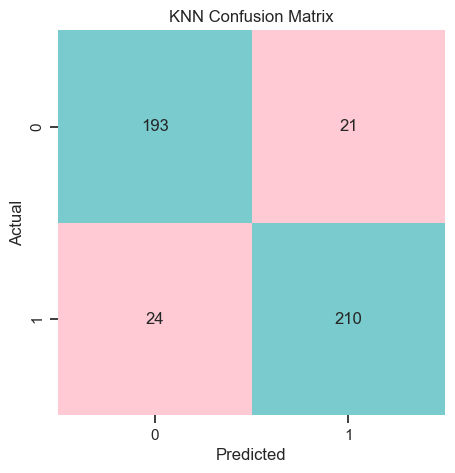

In [97]:
fig = plt.figure(figsize=(5, 5))
sns.heatmap(knn_confusion_matrix, annot=True, fmt='d', cmap=palette, cbar=False)
plt.title('KNN Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

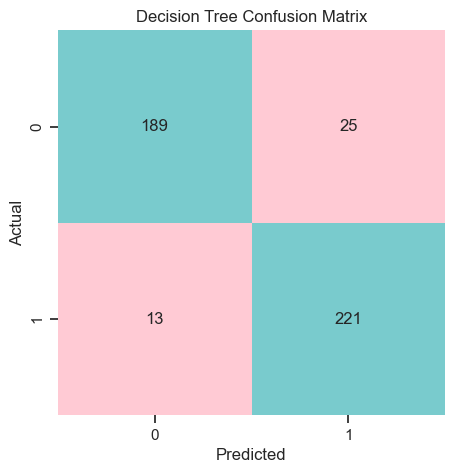

In [98]:
fig = plt.figure(figsize=(5, 5))
sns.heatmap(decision_tree_confusion_matrix, annot=True, fmt='d', cmap=palette, cbar=False)
plt.title('Decision Tree Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Grid Search

1. `Penalty`: Logistic regression can use either L1 or L2 regularization to prevent overfitting. The `penalty` hyperparameter controls which type of regularization to use. L1 regularization can be used to perform feature selection by setting some coefficients to zero, while L2 regularization can be used to shrink the coefficients towards zero.

2. `C`: The `C` hyperparameter controls the strength of the regularization. A smaller value of `C` results in stronger regularization, which can help prevent overfitting but may also lead to underfitting. A larger value of `C` results in weaker regularization, which can lead to overfitting but may also improve the model's performance on the training data.

3. `Solver`: Logistic regression can use different optimization algorithms to find the optimal coefficients. The `solver` hyperparameter controls which algorithm to use. The most common solvers are 'lbfgs', 'liblinear', 'newton-cg', 'sag', and 'saga'. The choice of solver can affect the speed and accuracy of the model.

4. `Max iterations`: The `max_iter` hyperparameter controls the maximum number of iterations for the solver to converge. If the solver does not converge within the maximum number of iterations, it will stop and return the current solution. Increasing the maximum number of iterations can improve the accuracy of the model but may also increase the training time.

5. `Class weight`: The `class_weight` hyperparameter can be used to adjust the weights of the classes to account for class imbalance. By default, logistic regression assumes that the classes are balanced, but if one class is much more common than the other, the model may be biased towards the majority class. The `class_weight` hyperparameter can be set to 'balanced' to automatically adjust the weights based on the number of samples in each class.

6. `scoring`: The scoring method which we want to use.

7. `n_jobs`: Number of jobs to run in parallel. `-1` means using all processors.

In [99]:
grid = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "penalty": ["l2"],
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}
logRegGrid = GridSearchCV(
    estimator=LogisticRegression(random_state = 1, solver='lbfgs', max_iter=10000),
    param_grid=grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)
logRegGrid.fit(x_train, y_train_class)
print(f"Best Accuracy: {logRegGrid.best_score_ * 100:2.2f}%")
print(f"Best Parameters: {logRegGrid.best_params_}")
print(f"Logistic Regression Accuracy: {logRegGrid.score(x_test, y_test_class) * 100:2.2f}%")

Best Accuracy: 91.24%
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression Accuracy: 92.19%


1. `n_neighbors`: The number of neighbors `k` to consider when making a prediction. A larger value of `k` can help reduce the effect of noise in the data, but may also lead to underfitting. A smaller value of `k` can help capture more complex patterns in the data, but may also lead to overfitting.

2. `weights`: The weight function used in prediction. The default is 'uniform', which gives equal weight to all neighbors. Another option is 'distance', which gives more weight to closer neighbors.
    * `uniform`: uniform weights. All points in each neighborhood are weighted equally.

    * `distance`: weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.


3. `algorithm`: The algorithm used to compute the nearest neighbors. The default is 'auto', which selects the most appropriate algorithm based on the input data. Other options include 'ball_tree', 'kd_tree', and 'brute'.

4. `leaf_size`: The size of the leaf node in the KD-tree or Ball-tree algorithm. A smaller value of `leaf_size` can lead to faster queries but may also increase the memory usage.

5. `p`: The power parameter for the Minkowski distance metric. The default is `p=2`, which corresponds to the Euclidean distance metric. Other values of `p` can be used to compute other distance metrics, such as Manhattan distance (`p=1`) or Chebyshev distance (`p=inf`).

6. `metric`: The distance metric to use for the tree. The default metric is `minkowski`, and with `p=2` is equivalent to the standard Euclidean metric.

In [100]:
grid = {
    "n_neighbors": list(range(1, 11)) + list(range(20, 81, 10)), 
    "metric": ["euclidean", "manhattan", "minkowski"],
    "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "p": [1, 2],
}
KNNGrid = GridSearchCV(
    estimator=KNeighborsClassifier(n_neighbors=NEIGHBORS),
    param_grid=grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)
KNNGrid.fit(x_train, y_train_class)
print(f"Best Accuracy: {KNNGrid.best_score_ * 100:2.2f}%")
print(f"Best Parameters: {KNNGrid.best_params_}")
print(f"KNN Accuracy: {KNNGrid.score(x_test, y_test_class) * 100:2.2f}%")

Best Accuracy: 89.56%
Best Parameters: {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 7, 'p': 1}
KNN Accuracy: 89.29%


1. `criterion`: The function used to measure the quality of a split. The default is 'gini', which uses the Gini impurity measure. Another option is 'entropy', which uses the information gain measure.

2. `max_depth`: The maximum depth of the decision tree. A larger value of `max_depth` can capture more complex patterns in the data, but may also lead to overfitting. A smaller value of `max_depth` can help prevent overfitting but may also lead to underfitting.

3. `min_samples_split`: The minimum number of samples required to split an internal node. A larger value of `min_samples_split` can help prevent overfitting but may also lead to underfitting.

4. `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A larger value of `min_samples_leaf` can help prevent overfitting but may also lead to underfitting.

5. `max_features`: The maximum number of features to consider when making a split. The default is 'auto', which uses all features. Another option is 'sqrt', which uses the square root of the number of features.

6. `class_weight`: The weight function used in the classification. The default is None, which means all classes have equal weight. Another option is 'balanced', which automatically adjusts the weights based on the number of samples in each class.

7. `splitter`: The strategy used to choose the split at each node. Supported strategies are `"best"` to choose the best split and `"random"` to choose the best random split.

In [101]:
grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": range(2, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 5),
    'random_state': [1]
}
decisionTreeGrid = GridSearchCV(
    estimator=DecisionTreeClassifier( random_state = 1),
    param_grid=grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1,
)
decisionTreeGrid.fit(x_train, y_train_class)
print(f"Best Accuracy: {decisionTreeGrid.best_score_ * 100:2.2f}%")
print(f"Best Parameters: {decisionTreeGrid.best_params_}")
print(f"Decision Tree Accuracy: {decisionTreeGrid.score(x_test, y_test_class) * 100:2.2f}%")

Best Accuracy: 92.86%
Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 1}
Decision Tree Accuracy: 93.30%


### Underfitting and Overfitting

`Overfitting` and `underfitting` are two common problems that can occur when building machine learning models. 

**`Overfitting:`** occurs when a model is too complex and fits the training data too closely, to the point where it captures noise in the data rather than the underlying patterns. This can lead to poor generalization performance, where the model performs well on the training data but poorly on new, unseen data. `Overfitting` can occur when a model has too many features, is too complex, or is trained for too long. `Overfitting` can be detected by comparing the performance of the model on the training data and the validation data. If the performance on the validation data is significantly worse than the performance on the training data, the model may be `overfitting`.

**`Underfitting:`** occurs when a model is too simple and cannot capture the underlying patterns in the data. This can lead to poor performance on both the training data and new, unseen data. `Underfitting` can occur when a model has too few features, is too simple, or is not trained for long enough. `Underfitting` can be detected by comparing the performance of the model on the training data and the validation data. If the performance on both the training data and the validation data is poor, the model may be `underfitting`.

To address `overfitting`, we can use techniques such as regularization, early stopping, or reducing the complexity of the model. Regularization adds a penalty term to the loss function to discourage large weights, while early stopping stops the training process when the performance on the validation data stops improving. To address `underfitting`, we can use techniques such as increasing the number of features, increasing the complexity of the model, or training the model for longer. However, it's important to balance the complexity of the model with the amount of data available, as a more complex model may require more data to avoid `overfitting`.

In [102]:
logRegTrain = LogisticRegression(**logRegGrid.best_params_)
logRegTrain.fit(x_train, y_train_class)
print(f'Logistic Regression Accuracy train data: {logRegTrain.score(x_train, y_train_class) * 100:2.2f}%')
logRegTest = LogisticRegression(**logRegGrid.best_params_)
logRegTest.fit(x_train, y_train_class)
print(f'Logistic Regression Accuracy test data: {logRegTest.score(x_test, y_test_class) * 100:2.2f}%')
print("----------------------------------------------------------")

DTTrain = DecisionTreeClassifier(**decisionTreeGrid.best_params_)
DTTrain.fit(x_train, y_train_class)
print(f'Decision Tree Accuracy train data: {DTTrain.score(x_train, y_train_class) * 100:2.2f}%')
DTTest = DecisionTreeClassifier(**decisionTreeGrid.best_params_)
DTTest.fit(x_train, y_train_class)
print(f'Decision Tree Accuracy test data: {DTTest.score(x_test, y_test_class) * 100:2.2f}%')
print("----------------------------------------------------------")

KNNTrain = KNeighborsClassifier(**KNNGrid.best_params_)
KNNTrain.fit(x_train, y_train_class)
print(f'KNN Accuracy train data: {KNNTrain.score(x_train, y_train_class) * 100:2.2f}%')
KNNTest = KNeighborsClassifier(**KNNGrid.best_params_)
KNNTest.fit(x_train, y_train_class)
print(f'KNN Accuracy test data: {KNNTest.score(x_test, y_test_class) * 100:2.2f}%')

Logistic Regression Accuracy train data: 91.52%
Logistic Regression Accuracy test data: 92.19%
----------------------------------------------------------
Decision Tree Accuracy train data: 94.59%
Decision Tree Accuracy test data: 93.30%
----------------------------------------------------------
KNN Accuracy train data: 92.02%
KNN Accuracy test data: 89.29%


### Changing the pre-processing

Preprocessing is an extremely important step in machine learning.  
we did change all parameters a lot to reach this results.  
For example k in KNN.

### Draw Decision Tree

In [103]:
#fig = plt.figure(figsize=(25,20))
#_ = tree.plot_tree(decisionTree, feature_names=['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer' ,'Recency', 'Complain', 'MntCoffee', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'UsedCampaignOffer', 'NumWebVisitsMonth'],  class_names=['PurchaseRate'], filled=True)
text_representation = tree.export_text(decisionTree)
print(text_representation)

|--- feature_10 <= -0.51
|   |--- feature_12 <= -0.37
|   |   |--- feature_14 <= 0.96
|   |   |   |--- feature_16 <= 5.45
|   |   |   |   |--- feature_15 <= 4.79
|   |   |   |   |   |--- feature_13 <= 0.49
|   |   |   |   |   |   |--- feature_12 <= -0.39
|   |   |   |   |   |   |   |--- class: HIGH
|   |   |   |   |   |   |--- feature_12 >  -0.39
|   |   |   |   |   |   |   |--- feature_0 <= -1.05
|   |   |   |   |   |   |   |   |--- class: LOW
|   |   |   |   |   |   |   |--- feature_0 >  -1.05
|   |   |   |   |   |   |   |   |--- class: HIGH
|   |   |   |   |   |--- feature_13 >  0.49
|   |   |   |   |   |   |--- feature_1 <= -0.30
|   |   |   |   |   |   |   |--- feature_13 <= 1.68
|   |   |   |   |   |   |   |   |--- class: LOW
|   |   |   |   |   |   |   |--- feature_13 >  1.68
|   |   |   |   |   |   |   |   |--- class: HIGH
|   |   |   |   |   |   |--- feature_1 >  -0.30
|   |   |   |   |   |   |   |--- class: HIGH
|   |   |   |   |--- feature_15 >  4.79
|   |   |   |   |   |---

## Ensemble Learning

#### Random Forest

Random Forest is an ensemble learning method that combines multiple decision trees to improve the performance of the model. Random Forest has several hyperparameters that can be tuned to improve the performance of the model. Here are some of the most important hyperparameters of Random Forest:

1. `n_estimators`: The number of decision trees in the Random Forest. A larger value of `n_estimators` can improve the performance of the model, but may also increase the training time and memory usage.

2. `criterion`: The function used to measure the quality of a split. The default is 'gini', which uses the Gini impurity measure. Another option is 'entropy', which uses the information gain measure.

3. `max_depth`: The maximum depth of the decision trees in the Random Forest. A larger value of `max_depth` can capture more complex patterns in the data, but may also lead to overfitting. A smaller value of `max_depth` can help prevent overfitting but may also lead to underfitting.

4. `min_samples_split`: The minimum number of samples required to split an internal node. A larger value of `min_samples_split` can help prevent overfitting but may also lead to underfitting.

5. `min_samples_leaf`: The minimum number of samples required to be at a leaf node. A larger value of `min_samples_leaf` can help prevent overfitting but may also lead to underfitting.

6. `max_features`: The maximum number of features to consider when making a split. The default is 'auto', which uses the square root of the number of features. Another option is 'sqrt', which uses the square root of the number of features.

7. `class_weight`: The weight function used in the classification. The default is None, which means all classes have equal weight. Another option is 'balanced', which automatically adjusts the weights based on the number of samples in each class.

8. `random_state`: Controls the randomness of the estimator. If an integer is given, the randomness will be deterministic and the results will be reproducible.

In [104]:
grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": list(range(2, 8)) + [None],
    "min_samples_split": range(2, 5),
    # "min_samples_leaf": range(1, 4),
    "random_state": [54]
}
forest_grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=grid,
    scoring="accuracy",
    cv=10,
    n_jobs=-1
)
forest_grid_search.fit(x_train, y_train_class)
print(f"Best Accuracy: {forest_grid_search.best_score_ * 100:5.2f}%")
print(f"Best Parameters: {forest_grid_search.best_params_}")
print(f"Random Forest Accuracy: {forest_grid_search.score(x_test, y_test_class) * 100:5.2f}%")

Best Accuracy: 93.69%
Best Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'random_state': 54}
Random Forest Accuracy: 93.75%


Text(0, 0.5, 'Accuracy')

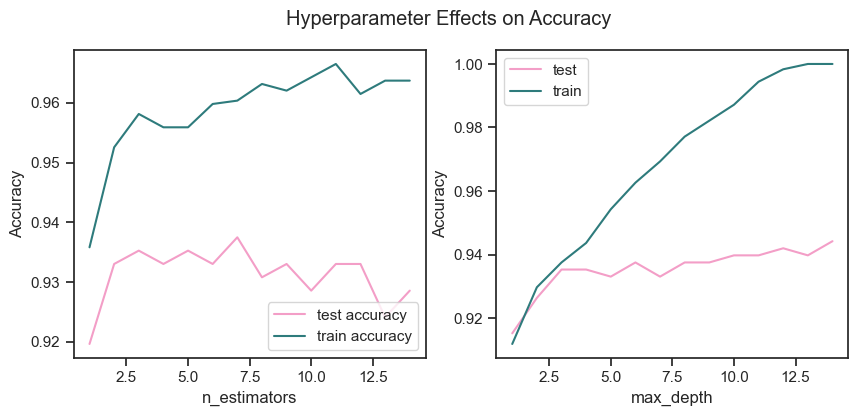

In [105]:
n_estimators_range = range(1, 15)
max_depth_range = range(1, 15)

plt.figure(figsize=(10, 4))
plt.suptitle('Hyperparameter Effects on Accuracy')
plt.subplot(1, 2, 1)

test_results = []
train_results = []

for estimator in n_estimators_range:
    forest = RandomForestClassifier(criterion="gini",  max_depth=7, min_samples_split=2, random_state=54, n_estimators=estimator)
    forest.fit(x_train, y_train_class)
    test_results.append(accuracy_score(y_test_class, forest.predict(x_test)))
    train_results.append(accuracy_score(y_train_class, forest.predict(x_train)))
    
plt.plot(n_estimators_range, test_results, color="#F39EC7", label="test accuracy")
plt.plot(n_estimators_range, train_results, color="#2E7B7C", label="train accuracy")
plt.legend(loc="lower right")
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
test_results = []
train_results = []

for depth in max_depth_range:
    forest = RandomForestClassifier(criterion="gini",  max_depth=depth, min_samples_split=2, random_state=54)
    forest.fit(x_train, y_train_class)
    test_results.append(accuracy_score(y_test_class, forest.predict(x_test)))
    train_results.append(accuracy_score(y_train_class, forest.predict(x_train)))
    
plt.plot(max_depth_range, test_results, color="#F39EC7", label="test")
plt.plot(max_depth_range, train_results, color="#2E7B7C", label="train")
plt.legend(loc="upper left")
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

Increasing the `n_estimators` and `max_depth` hyperparameters in the `RandomForestClassifier` can help improve the performance of the model in different ways.

Increasing the `n_estimators` hyperparameter increases the number of decision trees in the Random Forest. This can help improve the performance of the model by reducing the variance of the model and making it more robust to noise in the data. By combining the predictions of multiple decision trees, the Random Forest can reduce the risk of overfitting and improve the generalization performance of the model. However, increasing the `n_estimators` hyperparameter can also increase the training time and memory usage of the model.

Increasing the `max_depth` hyperparameter increases the maximum depth of the decision trees in the Random Forest. This can help improve the performance of the model by allowing the decision trees to capture more complex patterns in the data. By increasing the depth of the decision trees, the Random Forest can learn more complex decision boundaries and improve the accuracy of the model. However, increasing the `max_depth` hyperparameter can also increase the risk of overfitting and lead to poor generalization performance on new, unseen data, As can be seen in the graph after 15 we see overfitting.

It's important to note that increasing these hyperparameters should be done with caution, as they can also increase the risk of overfitting and lead to poor generalization performance. It's important to balance the complexity of the model with the amount of data available, and to use techniques such as cross-validation and regularization to prevent overfitting.

### Compare decision Tree and Random Forest

In [106]:
tree = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_leaf=8, random_state=54, splitter="random")
y_train_binary = y_train_class.apply(lambda x: 0 if x == "LOW" else 1)
y_test_binary = y_test_class.apply(lambda x: 0 if x == "LOW" else 1)

_, treeBias, treeVar = bias_variance_decomp(
    estimator=tree,
    X_train=x_train.values,
    y_train=y_train_binary.values,
    X_test=x_test.values,
    y_test=y_test_binary.values,
    loss="mse",
    num_rounds=100,
    random_seed=1,
)

forest = RandomForestClassifier(criterion="gini",  max_depth=7, min_samples_split=2, random_state=54)
_, forestBias, forestVar = bias_variance_decomp(
    estimator=forest,
    X_train=x_train.values,
    y_train=y_train_binary.values,
    X_test=x_test.values,
    y_test=y_test_binary.values,
    loss="mse",
    num_rounds=100,
    random_seed=1,
)

print(f"Tree Bias      : {treeBias:2.2f}")
print(f"Tree Variance  : {treeVar:2.2f}")
print(f"Forest Bias    : {forestBias:2.2f}")
print(f"Forest Variance: {forestVar:2.2f}")

Tree Bias      : 0.05
Tree Variance  : 0.05
Forest Bias    : 0.05
Forest Variance: 0.01


As we predicted the random forest's variance was less, but bias was higher which can be due to these reasons:

1. Hyperparameter tuning: The performance of Random Forest models can be highly sensitive to the choice of hyperparameters, such as the number of trees, the maximum depth of the trees, and the minimum number of samples required to split a node. If the hyperparameters of the Random Forest model are not tuned properly, it may result in a model with higher bias.

2. Feature selection: Random Forest models can be sensitive to the choice of features used to train the model. If the features used in the Random Forest model are not informative or relevant to the target variable, it may result in a model with higher bias.

3. Data quality: The performance of Random Forest models can be affected by the quality of the data used to train the model. If the data contains missing values, outliers, or other types of noise, it may result in a model with higher bias.

4. Sample size: Random Forest models can be sensitive to the size of the training data. If the training data is too small, it may result in a model with higher bias.

## Differential Privacy

### How Noise help

The fundamental concept behind adding noise to data is to obscure the overall pattern of the dataset and the specific characteristics of individuals, such as their identities or personal information. By doing so, the presence of noise can make it harder for adversaries to discern sensitive information or to identify individuals based on the data.


### Difference of Laplace and exponential noise addition

Laplace and exponential noise addition methods differ in terms of the shape of their probability distributions, their impact on the skewness of the perturbations, and their resilience to outliers. 

### Laplace 

In [107]:
SCALE = 0.5 

In [108]:

#laplace_noise_train_y = np.random.laplace(scale=SCALE, size=y_train_binary.shape)
#laplace_noise_test_y = np.random.laplace(scale=SCALE, size=y_test_binary.shape)
laplace_noise_train_x = np.random.laplace(scale=SCALE, size=x_train.shape)
laplace_noise_test_x = np.random.laplace(scale=SCALE, size=x_test.shape)

x_train_noisy = x_train + laplace_noise_train_x
x_test_noisy = x_test + laplace_noise_test_x
#y_train_noisy = y_train_binary + laplace_noise_train_y
#y_test_noisy = y_test_binary+ laplace_noise_test_y


tree1 = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_leaf=8, random_state=54, splitter="random")
tree1.fit(x_train, y_train_class)
print(f'Accuracy pure data: {tree1.score(x_train_noisy, y_train_class) * 100:2.2f}%')

tree2 = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_leaf=8, random_state=54, splitter="random")
tree2.fit(x_train_noisy, y_train_binary)
print(f'Accuracy noisy data: {tree2.score(x_test_noisy, y_test_binary) * 100:2.2f}%')

Accuracy pure data: 76.23%
Accuracy noisy data: 81.92%


## Gradient Boosting

### Difference e between boosting tree and decision tree

while decision trees focus on creating a single tree-based model, boosting techniques, such as AdaBoost, Gradient Boosting, and XGBoost, work on creating an ensemble of models, typically decision trees, to enhance prediction capabilities.


### XGBoost

1. Weak Learners (Decision Trees): At its core, XGBoost builds an ensemble of weak learners, typically decision trees. These decision trees are often shallow, meaning they don't grow too deep, which helps to reduce overfitting. By combining the predictions of multiple weak learners, XGBoost aims to create a strong learner with improved accuracy.

2. Objective Function: XGBoost uses a regularized objective function that comprises two main parts: a loss function that measures the difference between the actual and predicted values, and a regularization term that controls the complexity of the model to prevent overfitting. By optimizing this objective function, XGBoost ensures that the model generalizes well to unseen data.

3. Gradient Boosting: XGBoost follows the principle of gradient boosting, where new models are trained to predict the residual errors (the difference between the actual and predicted values) of the existing ensemble. This sequential process allows the subsequent models to focus on the mistakes of the previous ones, gradually reducing the overall error.

4. Tree Pruning: XGBoost includes techniques like tree pruning to limit the growth of individual trees. Pruning helps to prevent the creation of overly complex trees that may overfit the training data.

5. Regularization: Regularization in XGBoost plays a crucial role in controlling model complexity. It penalizes overly complex models, discouraging them from being selected as part of the final ensemble.

6. Parallel and Distributed Computing: XGBoost is designed for efficiency and scalability. It can leverage parallel and distributed computing to train models on large datasets more quickly, making it suitable for big data environments.

Overall, XGBoost's success can be attributed to its combination of advanced algorithmic features, optimization for speed and performance, and its ability to handle a wide range of data types and problem complexities.


In [109]:
xgb = XGBClassifier()

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 200],
    'gamma': [0, 1, 5]
}

xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=params, cv=5, scoring="accuracy")
xgb_grid_search.fit(x_train, y_train_binary)
print(f"Best Accuracy: {xgb_grid_search.best_score_ * 100:2.2f}%")
print(f"Best Parameters: {xgb_grid_search.best_params_}")
print(f"Gradient-boosting Accuracy: {xgb_grid_search.score(x_test, y_test_binary) * 100:2.2f}%")

Best Accuracy: 93.86%
Best Parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 50}
Gradient-boosting Accuracy: 93.75%
